In [5]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [6]:
experiment_name = "best_features_time"
project_name="best_features_time",
run_name="best_features_time"
domain="time"

In [7]:
binary_classification=True
plot_histograms_choice=False

# Environment Setup & Imports

In [8]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [9]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [10]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [11]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [12]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [13]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [14]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [15]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [16]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [17]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 161 files into a DataFrame with shape (200093, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (200093, 16)


In [18]:
df_SIZA = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 16)


In [19]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=False,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    domains_to_include=[domain]
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected domains: ['time']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 16)


In [20]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [21]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [22]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [23]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [24]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [25]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,639
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(246359, 16)"
5,Transformed data shape,"(246359, 16)"
6,Transformed train set shape,"(172451, 16)"
7,Transformed test set shape,"(73908, 16)"
8,Numeric features,15
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

## Add aditional metrics

In [26]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [27]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001AF4D0A0E00>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001AF4D0A1...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001AF4D0A1...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [28]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [29]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.9697,0.9916,0.9697,0.9696,0.9694,0.9116,0.9122,0.9468,0.0303,0.8708,0.0879
1,0.9686,0.9906,0.9686,0.9685,0.9683,0.9081,0.9089,0.9440,0.0314,0.8659,0.0928
2,0.9685,0.9893,0.9685,0.9683,0.9681,0.9076,0.9084,0.9437,0.0315,0.8652,0.0983
3,0.9635,0.9896,0.9635,0.9632,0.9631,0.8931,0.8939,0.9367,0.0365,0.8458,0.0997
4,0.8170,0.7631,0.8170,0.8258,0.8207,0.4979,0.4994,0.7599,0.1830,0.4468,6.4754
5,0.9690,0.9906,0.9690,0.9688,0.9687,0.9096,0.9101,0.9473,0.0310,0.8683,0.0935
6,0.9672,0.9901,0.9672,0.9670,0.9668,0.9038,0.9046,0.9417,0.0328,0.8601,0.0976
7,0.9685,0.9906,0.9685,0.9683,0.9682,0.9082,0.9087,0.9460,0.0315,0.8663,0.0938
8,0.9646,0.9897,0.9646,0.9643,0.9642,0.8963,0.8970,0.9387,0.0354,0.8501,0.0996


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/04 11:09:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [30]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [31]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,skewness,1550
1,kurtosis,1422
2,mean,1238
3,crest,1200
4,entropy,1170
5,shape,1090
6,medianFreq,1075
7,impulse,993
8,bandwidth,964
9,meanFreq,951


In [32]:
add_top_features(lightgbm_top_features, top_n=3)

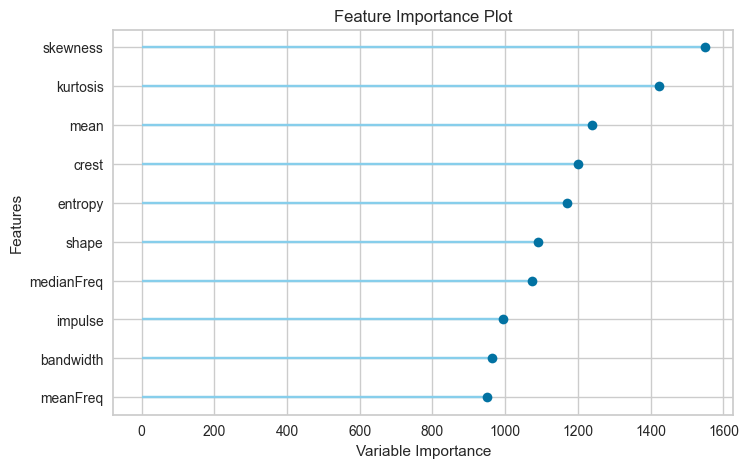

In [33]:
plot_model(lightgbm, plot='feature')

In [34]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9701,0.9913,0.9701,0.9699,0.9697,0.9124,0.9131,0.9466,0.0299,0.8719,0.0884


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [35]:
predictions_lightgbm

,crest,mean,medianFreq,std,rms,entropy,ptp,shape,impulse,bandwidth,skewness,meanFreq,kurtosis,energy,clearance,Label,prediction_label,prediction_score
93960,-0.595294,0.073408,-1.624495,-0.515631,-0.492250,0.184032,-0.674656,-0.365928,-0.509674,0.338588,0.106153,-1.250423,-0.142341,-0.237836,-0.808029,damaged,damaged,0.9997
371,-0.137891,0.058612,1.582892,-0.621327,-0.589200,0.181996,-0.794455,-0.031757,-0.134951,0.900601,-0.072342,0.700811,-0.081702,-0.240687,-1.096320,healthy,healthy,0.9956
33266,0.162632,0.056319,-0.063264,-0.622554,-0.590345,0.181980,-0.788795,-0.087409,0.073820,1.190149,-0.063216,-0.071259,-0.089386,-0.240701,-1.068598,healthy,healthy,0.9998
238774,0.591589,0.033096,-0.242809,-0.127309,-0.136916,0.186596,-0.051146,-0.002132,0.398757,-0.915037,0.167115,-0.543695,-0.073693,-0.199561,0.412783,damaged,damaged,0.9716
210317,-0.224380,0.033394,-0.223067,-0.453998,-0.435811,0.185095,-0.571356,0.712591,-0.089825,-1.403214,0.078050,-0.584476,-0.009010,-0.234678,-0.517015,damaged,damaged,0.9873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241132,0.946953,0.036482,-0.229193,-0.444468,-0.427159,0.184907,-0.459822,1.758543,0.994946,-0.952561,-0.047157,-0.542780,0.270062,-0.234096,-0.094569,damaged,damaged,0.8664
214791,0.859693,0.035452,-0.216777,-0.421478,-0.406114,0.185382,-0.413760,1.173851,0.815125,-0.712169,-0.047884,-0.575204,0.268881,-0.232573,-0.085377,damaged,damaged,0.9232
165165,2.730115,0.058127,1.888254,0.228228,0.188437,0.156779,1.176236,1.581429,2.368965,1.183981,-1.262784,1.900277,0.607855,-0.126170,2.440449,damaged,damaged,1.0000
217690,-0.162111,0.038995,-0.199653,0.201626,0.164117,0.170050,0.278279,-0.145207,-0.169209,-0.608206,0.444060,0.181994,-0.093651,-0.132923,0.501702,damaged,damaged,0.8829


In [36]:
get_incorrect_predictions(predictions_lightgbm)

,crest,mean,medianFreq,std,rms,entropy,ptp,shape,impulse,bandwidth,skewness,meanFreq,kurtosis,energy,clearance,Label,prediction_label,prediction_score
258524,0.949561,0.036464,-1.315493,-0.637307,-0.602333,0.181825,-0.806982,1.018010,0.854643,0.464823,-0.407115,-1.784974,0.131417,-0.240823,-1.057003,healthy,damaged,0.9578
255723,-0.400318,0.035643,-0.160991,-0.182074,-0.187058,0.187372,-0.243538,0.027741,-0.316864,-0.968132,0.147473,-0.329926,-0.086570,-0.207612,-0.104728,healthy,damaged,0.5035
208936,-0.433099,0.033842,-0.185029,0.173702,0.138583,0.173318,0.201264,-0.340450,-0.390895,-0.602855,0.019555,-0.017250,-0.130973,-0.139794,0.300450,healthy,damaged,0.8268
202856,-0.042167,0.030382,-0.204121,-0.134430,-0.143407,0.186095,-0.108780,0.306646,-0.014115,-0.927585,0.103309,-0.437911,-0.026063,-0.200652,0.139272,healthy,damaged,0.9964
212285,0.009228,0.032624,-0.122550,-0.008499,-0.028174,0.183546,0.079821,-0.227714,-0.058602,-0.466558,0.054186,0.205681,-0.099723,-0.179110,0.310253,damaged,healthy,0.5279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240598,0.223008,0.036515,-0.216081,-0.405950,-0.391927,0.185637,-0.474286,1.366387,0.354228,-2.176739,0.015472,-0.506985,0.119186,-0.231459,-0.224722,damaged,healthy,0.5544
262404,-0.040433,0.025626,-0.194695,0.165457,0.131088,0.171227,0.371228,0.261995,-0.019632,-0.604599,0.391404,0.088915,-0.025749,-0.141767,0.566100,healthy,damaged,0.8201
252058,-0.656599,0.032778,-0.251323,-0.052295,-0.068260,0.184706,-0.098878,0.103257,-0.493518,-0.913413,0.036508,-0.575107,-0.110070,-0.187125,-0.033690,damaged,healthy,0.5765
206916,-0.347732,0.041697,-0.276549,-0.151280,-0.158916,0.187132,-0.181929,-0.061274,-0.291088,-0.883363,0.231444,-0.605074,-0.101904,-0.203200,-0.043652,healthy,damaged,0.9912


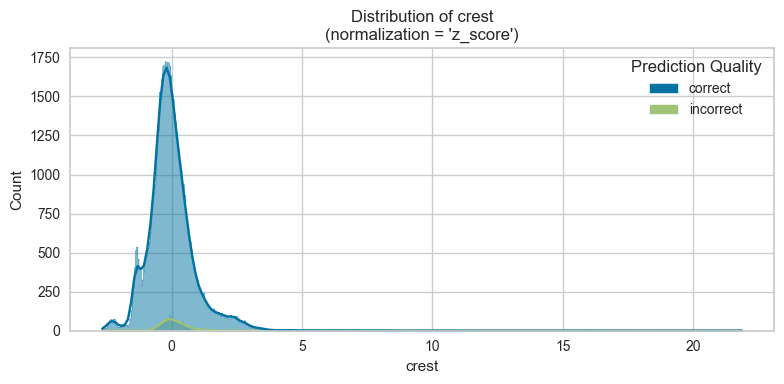

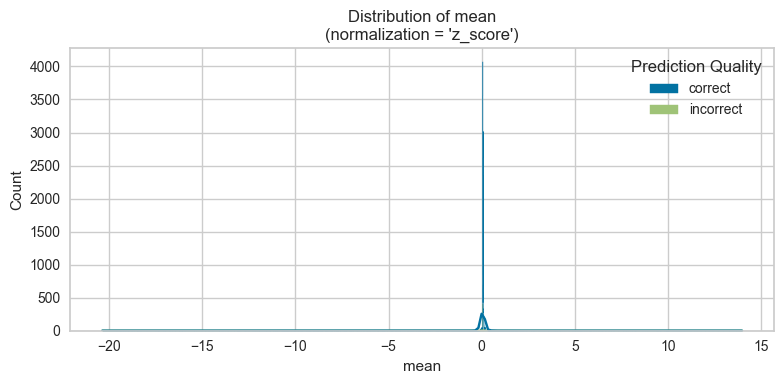

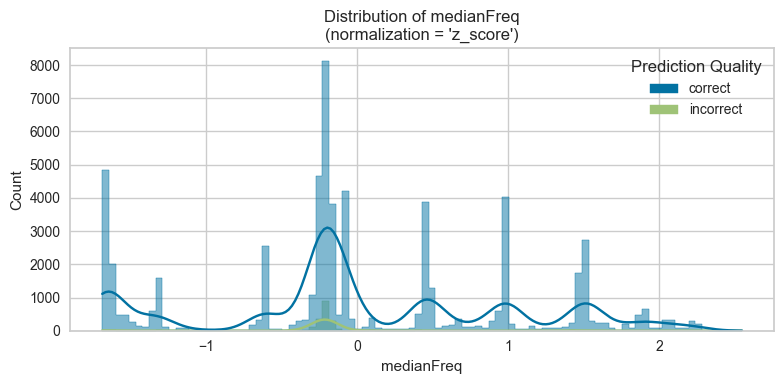

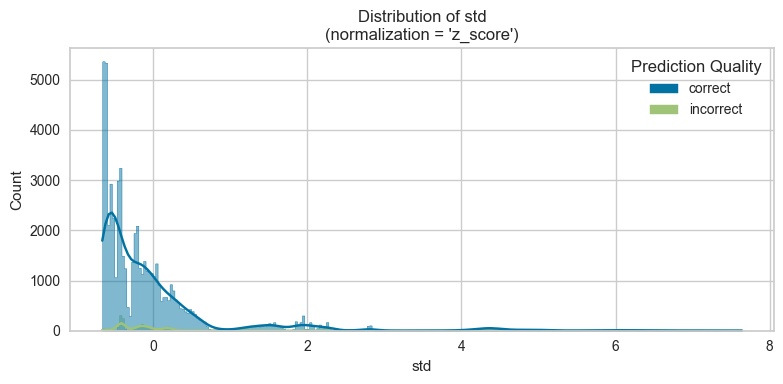

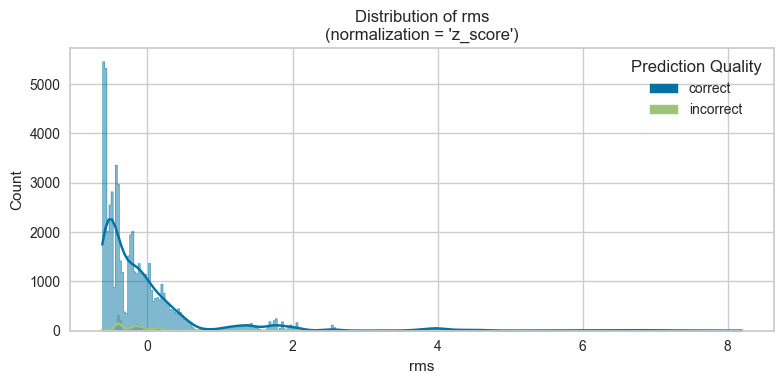

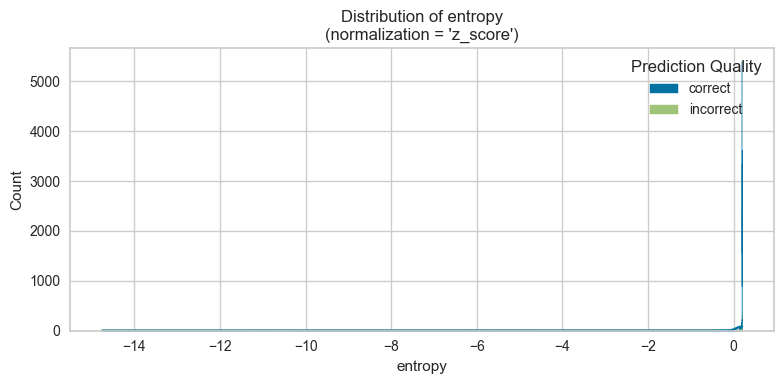

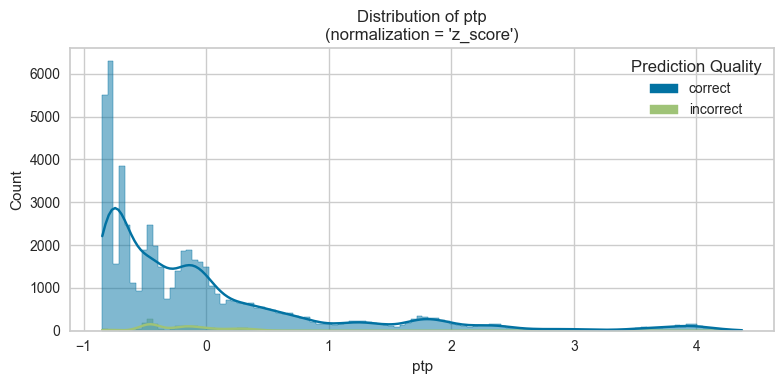

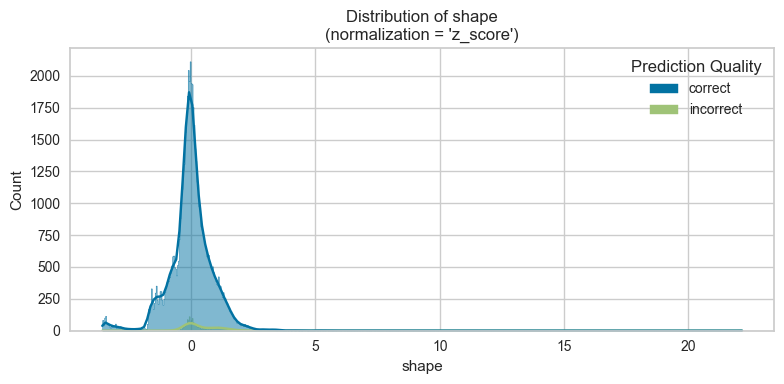

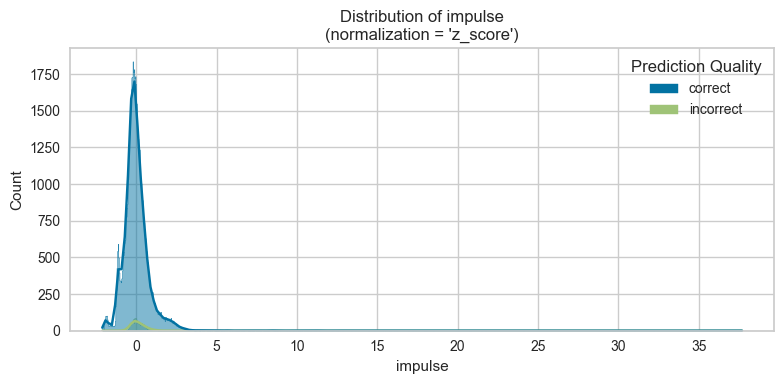

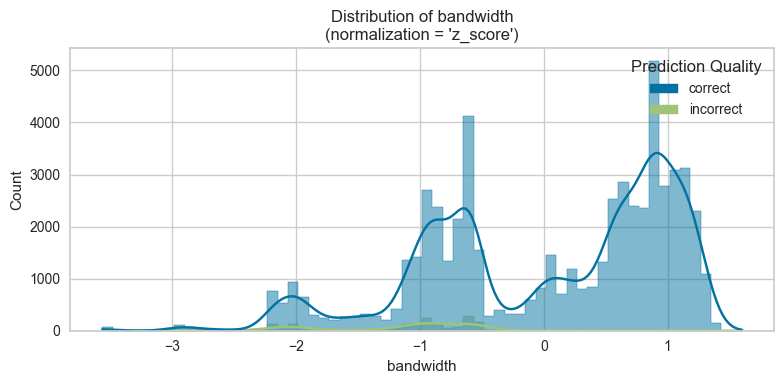

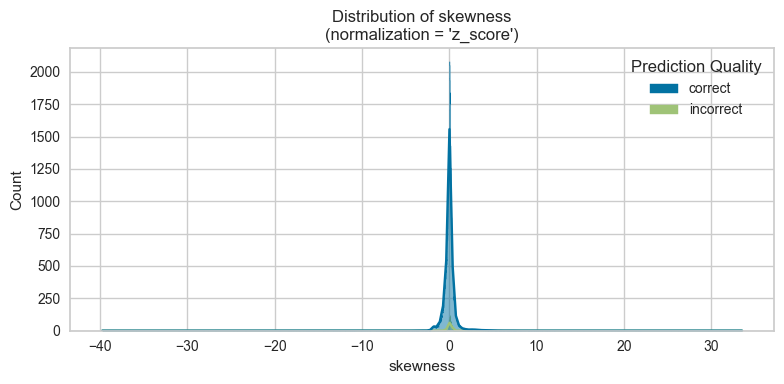

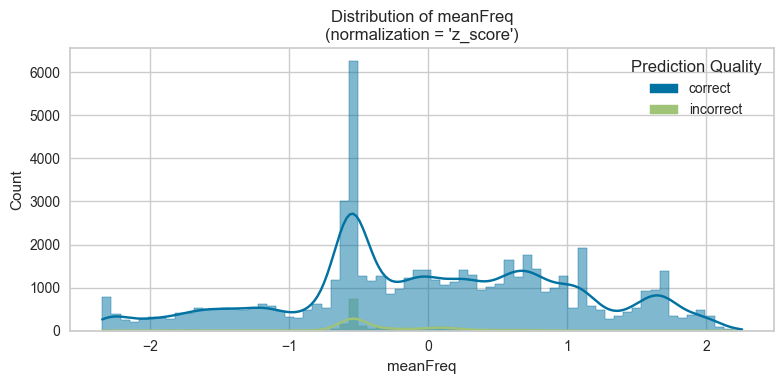

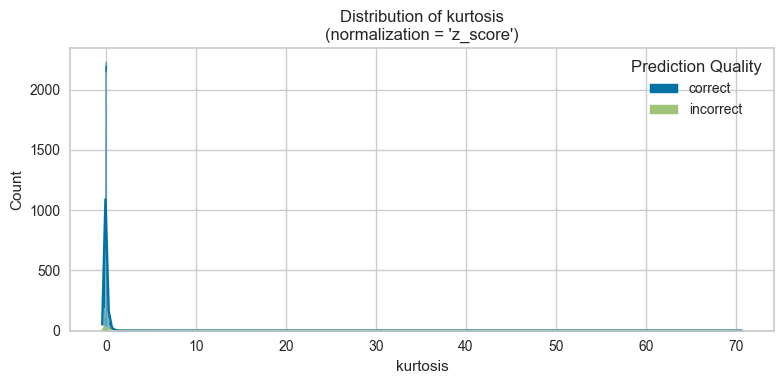

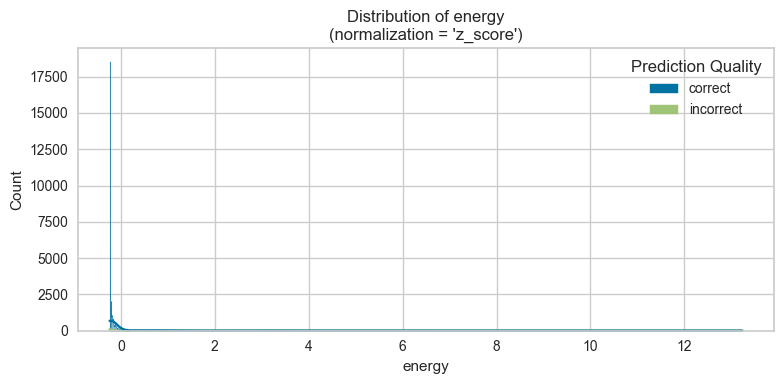

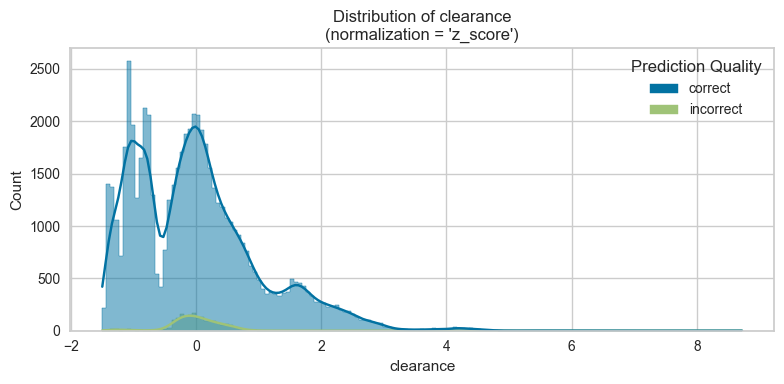

In [37]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [38]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [39]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [40]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,std,0.121944
1,medianFreq,0.121389
2,rms,0.117629
3,energy,0.098723
4,ptp,0.089974
5,meanFreq,0.080254
6,bandwidth,0.074236
7,clearance,0.052007
8,entropy,0.046735
9,skewness,0.046695


In [42]:
add_top_features(rf_top_features, top_n=3)

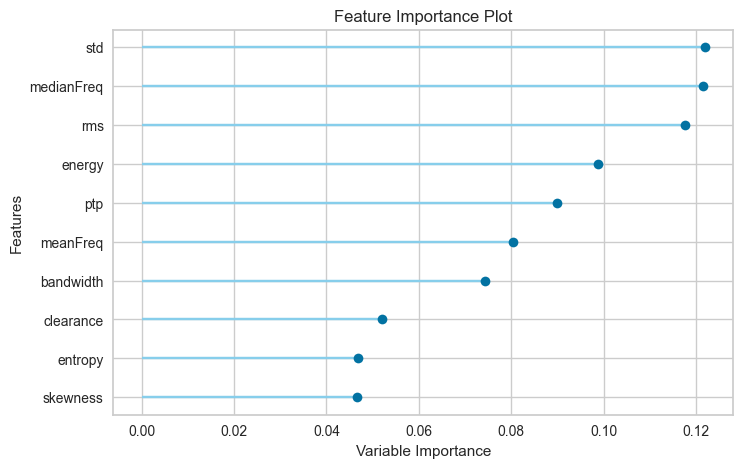

In [43]:
plot_model(rf, plot='feature')

In [44]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9759,0.9951,0.9759,0.9760,0.9755,0.9289,0.9301,0.9517,0.0241,0.8944,0.0792


In [45]:
get_incorrect_predictions(predictions_rf)

,crest,mean,medianFreq,std,rms,entropy,ptp,shape,impulse,bandwidth,skewness,meanFreq,kurtosis,energy,clearance,Label,prediction_label,prediction_score
258524,0.949561,0.036464,-1.315493,-0.637307,-0.602333,0.181825,-0.806982,1.018010,0.854643,0.464823,-0.407115,-1.784974,0.131417,-0.240823,-1.057003,healthy,damaged,0.77
202856,-0.042167,0.030382,-0.204121,-0.134430,-0.143407,0.186095,-0.108780,0.306646,-0.014115,-0.927585,0.103309,-0.437911,-0.026063,-0.200652,0.139272,healthy,damaged,0.81
208611,0.535251,0.030392,-0.198634,0.211792,0.173465,0.169814,0.388902,-0.246010,0.315074,-0.584867,0.356421,0.236240,-0.113799,-0.130352,0.898933,healthy,damaged,0.52
212285,0.009228,0.032624,-0.122550,-0.008499,-0.028174,0.183546,0.079821,-0.227714,-0.058602,-0.466558,0.054186,0.205681,-0.099723,-0.179110,0.310253,damaged,healthy,0.56
259259,0.451972,0.037583,-0.232261,-0.432703,-0.416416,0.185367,-0.498686,0.917473,0.455757,-0.885333,-0.049150,-0.576363,0.084521,-0.233338,-0.254490,healthy,damaged,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262404,-0.040433,0.025626,-0.194695,0.165457,0.131088,0.171227,0.371228,0.261995,-0.019632,-0.604599,0.391404,0.088915,-0.025749,-0.141767,0.566100,healthy,damaged,0.81
202298,-0.034782,0.034206,-0.187715,-0.195733,-0.199546,0.187615,-0.161816,-0.139468,-0.076681,-0.922642,0.136463,-0.291326,-0.078097,-0.209481,0.011078,healthy,damaged,0.65
206916,-0.347732,0.041697,-0.276549,-0.151280,-0.158916,0.187132,-0.181929,-0.061274,-0.291088,-0.883363,0.231444,-0.605074,-0.101904,-0.203200,-0.043652,healthy,damaged,0.89
200497,0.219733,0.033159,-0.222966,-0.400006,-0.386435,0.185834,-0.452461,1.091975,0.307008,-1.949263,0.047990,-0.521056,0.064846,-0.231010,-0.226820,healthy,damaged,0.57


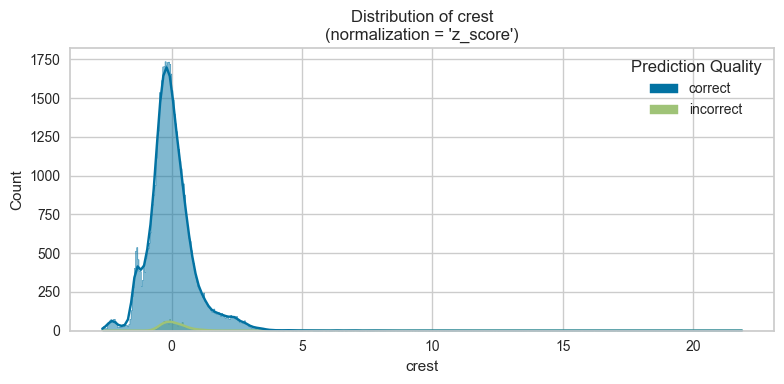

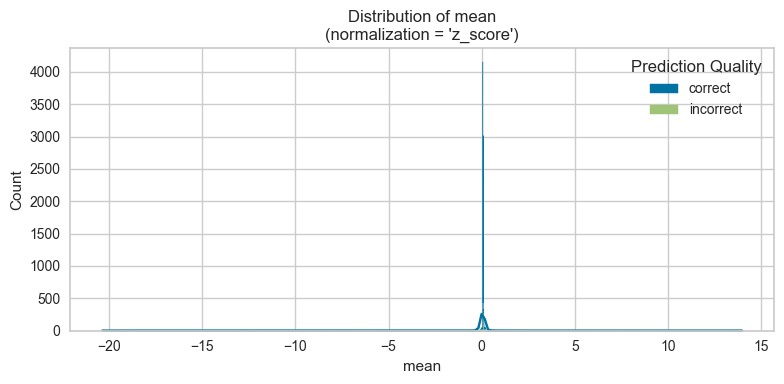

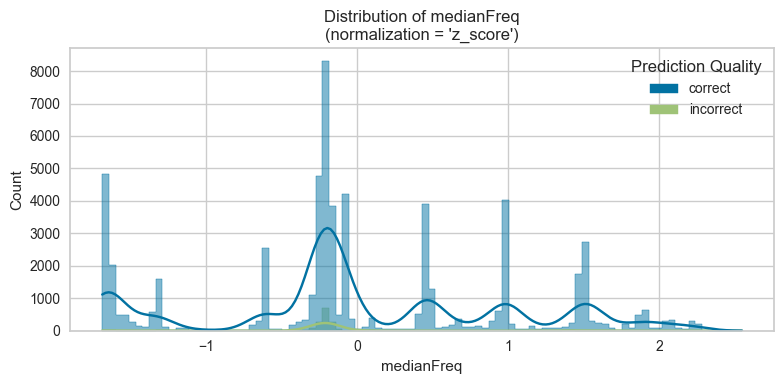

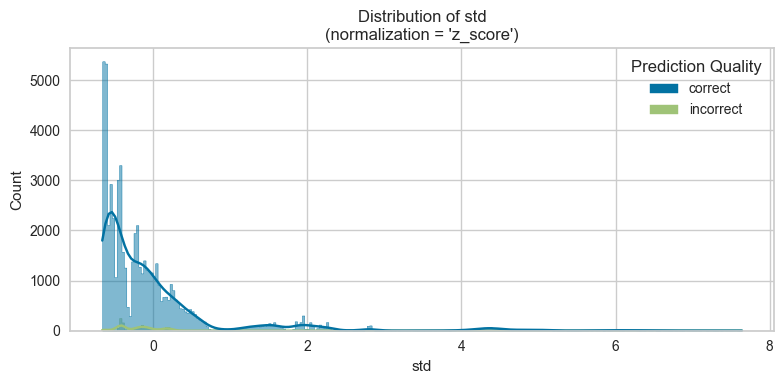

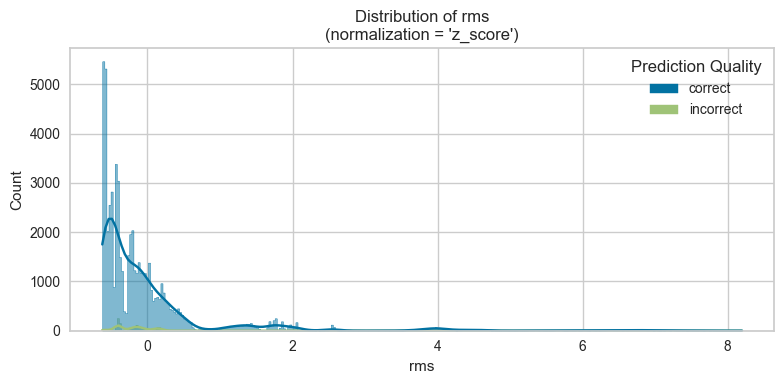

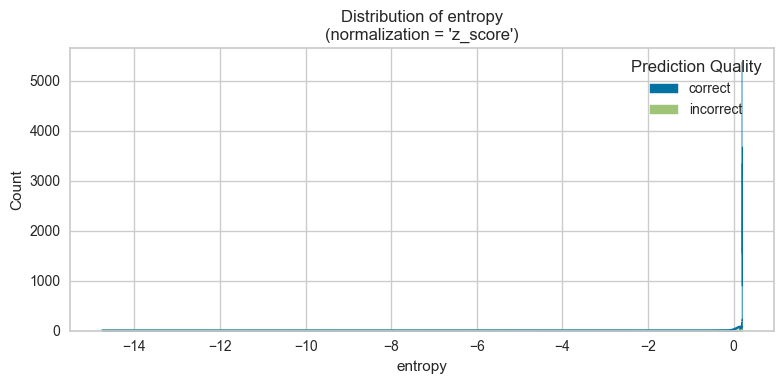

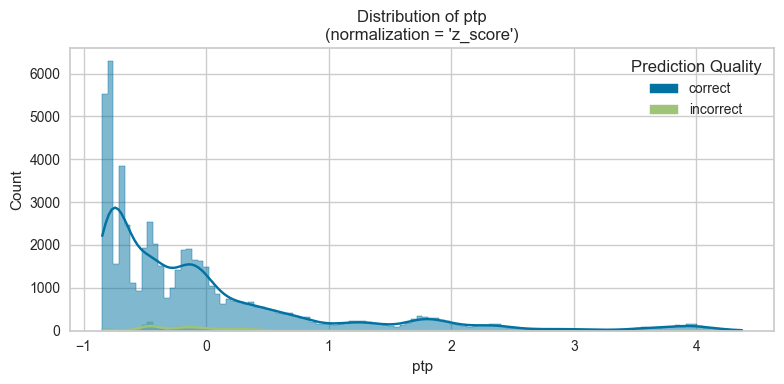

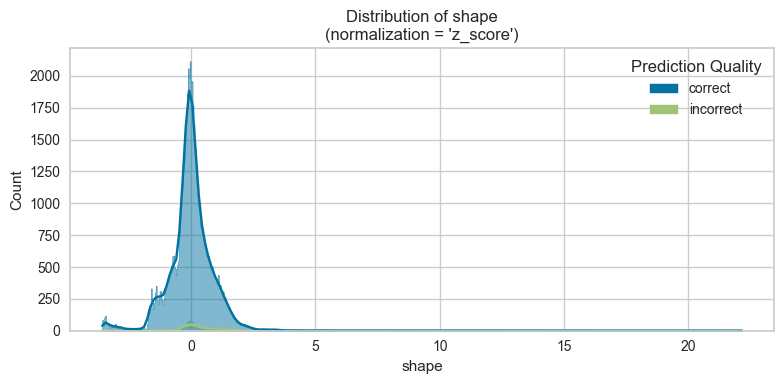

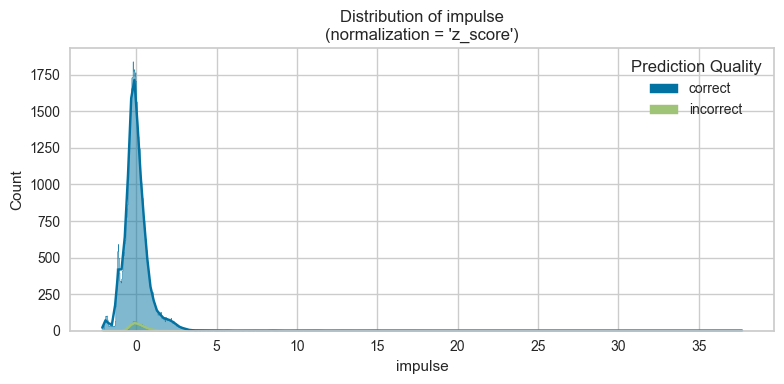

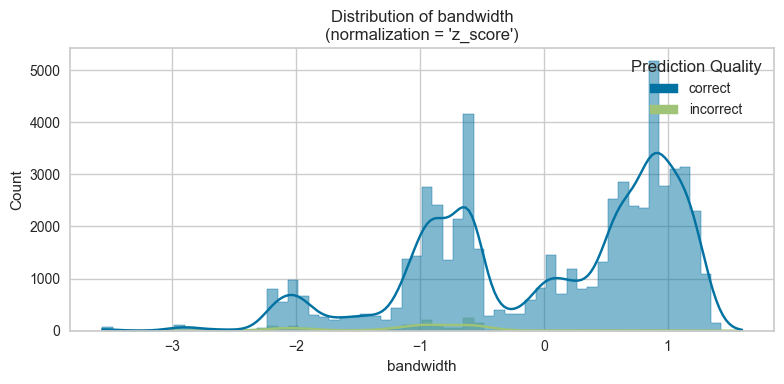

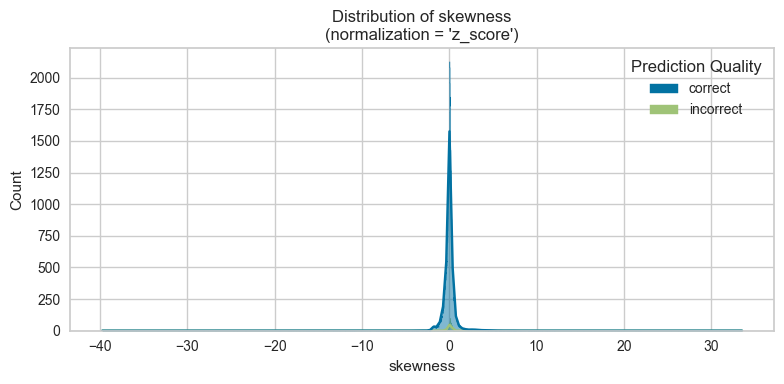

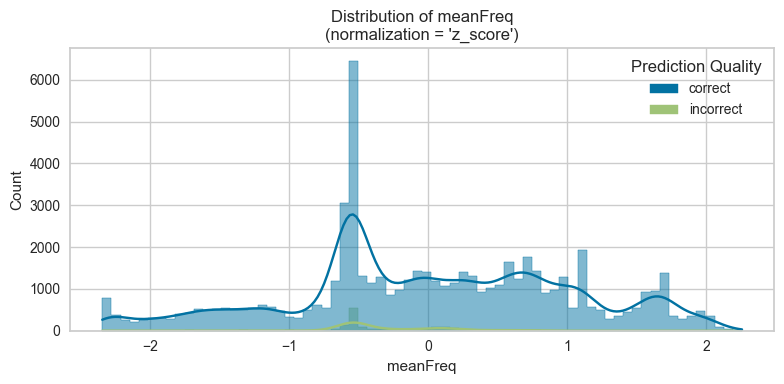

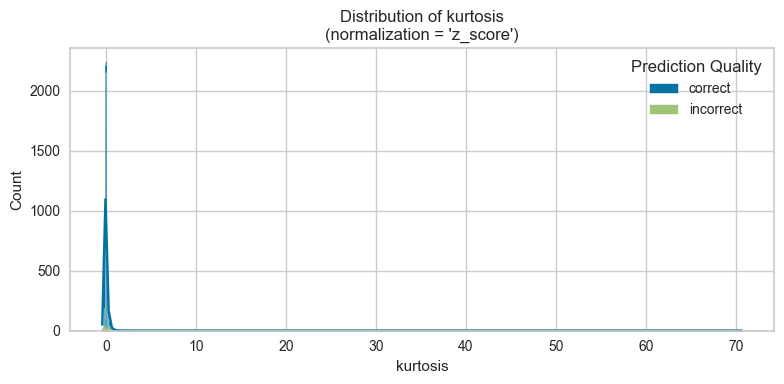

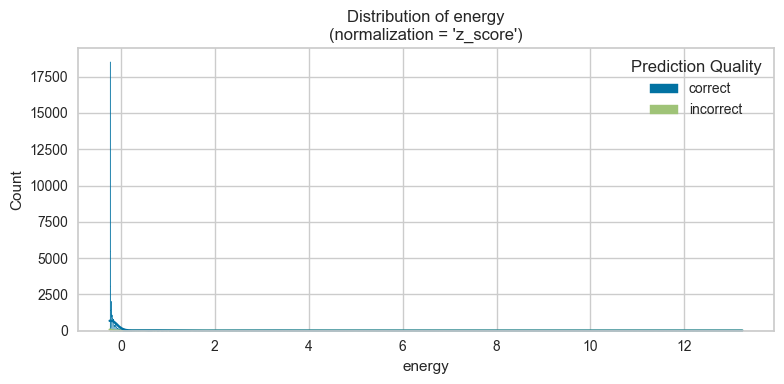

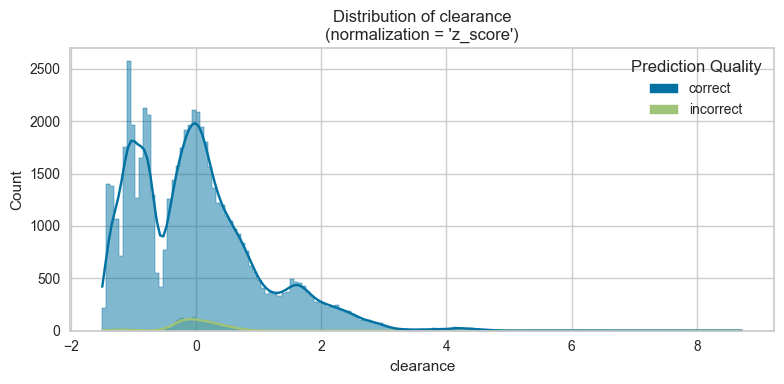

In [46]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [47]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [48]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [49]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [50]:
svm_top_features = get_svm_feature_importance_df(svm, features_df_training_normalized)
svm_top_features

,Features,importance
0,entropy,24.130995
1,ptp,9.595981
2,energy,8.520593
3,clearance,6.794969
4,rms,3.100921
5,impulse,2.848988
6,std,1.877916
7,crest,1.272466
8,medianFreq,1.191929
9,meanFreq,0.932554


In [51]:
add_top_features(svm_top_features, top_n=3)

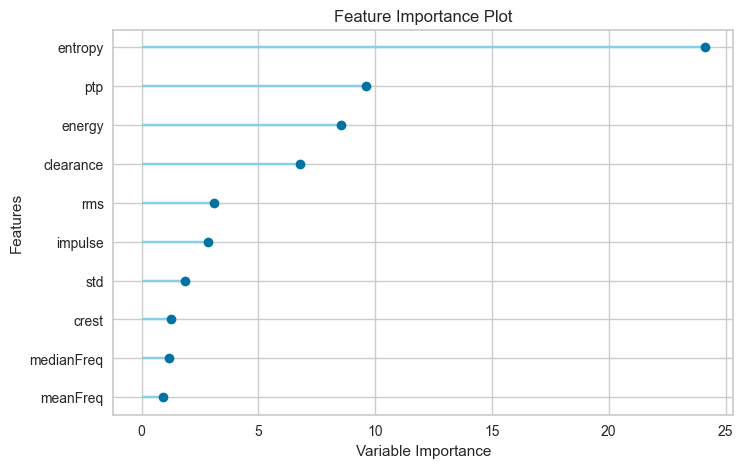

In [52]:
plot_model(svm, plot='feature')

In [53]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8579,0,0.8579,0.8504,0.8484,0.5450,0.5581,0.7437,0.1421,0.4594,0


In [54]:
get_incorrect_predictions(predictions_svm)

,crest,mean,medianFreq,std,rms,entropy,ptp,shape,impulse,bandwidth,skewness,meanFreq,kurtosis,energy,clearance,Label,prediction_label
261113,-0.201324,0.036416,-0.226035,-0.018097,-0.036985,0.183979,-0.000295,-0.177289,-0.202111,-0.949756,0.094470,-0.556726,-0.122904,-0.180919,0.204035,healthy,damaged
207745,-0.817718,0.036146,-0.192099,-0.037686,-0.054912,0.185946,-0.166550,-0.686273,-0.706493,-1.105632,-0.206209,-0.305068,-0.191703,-0.184518,-0.152971,healthy,damaged
255723,-0.400318,0.035643,-0.160991,-0.182074,-0.187058,0.187372,-0.243538,0.027741,-0.316864,-0.968132,0.147473,-0.329926,-0.086570,-0.207612,-0.104728,healthy,damaged
207040,0.134858,0.039656,-0.220380,-0.067949,-0.082632,0.184664,0.060171,0.206646,0.100614,-0.906215,0.162263,-0.596088,-0.036778,-0.189864,0.324422,healthy,damaged
254381,0.060705,0.037702,-0.237748,-0.410098,-0.395739,0.185486,-0.466383,1.609793,0.265529,-2.137274,-0.080981,-0.556680,0.163145,-0.231765,-0.275616,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6607,-1.490078,0.058673,0.882884,-0.504485,-0.482263,0.184481,-0.706123,-1.565416,-1.258066,0.673524,-0.001883,0.953232,-0.299242,-0.237358,-1.023256,healthy,damaged
19837,-0.447340,0.061301,1.492756,-0.522852,-0.499058,0.183886,-0.666447,-0.451725,-0.416143,0.218805,-0.110500,1.536079,-0.168853,-0.238143,-0.796208,healthy,damaged
100049,-0.345024,0.064914,-1.631556,-0.648307,-0.613250,0.181730,-0.829445,-0.269257,-0.318231,0.755664,-0.266005,-1.000685,-0.112554,-0.240891,-1.297854,damaged,healthy
205706,0.161131,0.035491,-0.213101,-0.444088,-0.426794,0.185292,-0.511299,0.467480,0.161734,-0.731065,0.048360,-0.531057,0.038563,-0.234071,-0.395557,healthy,damaged


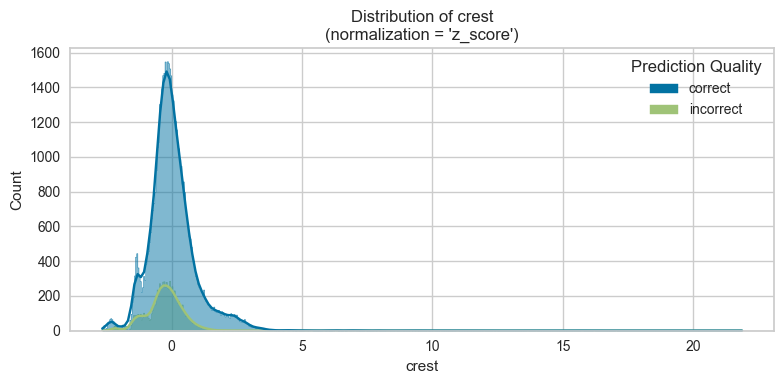

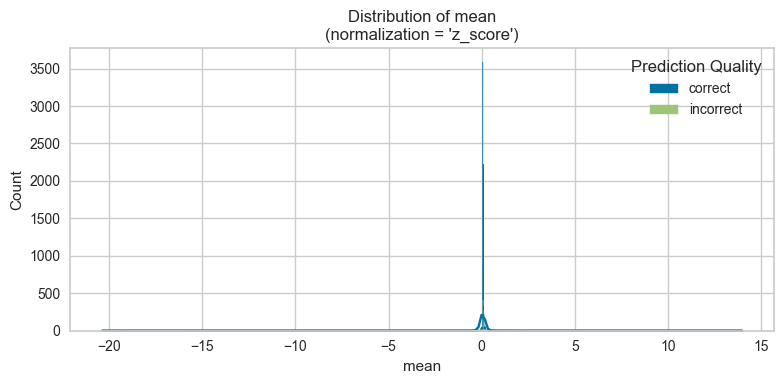

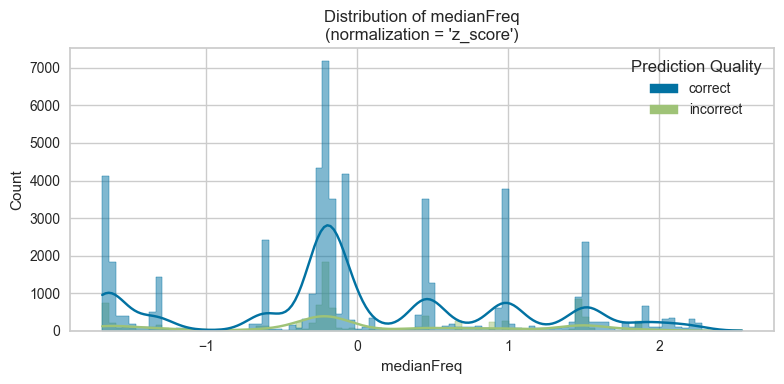

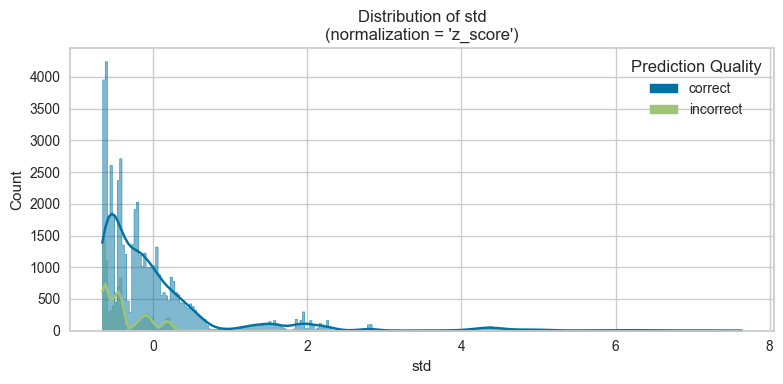

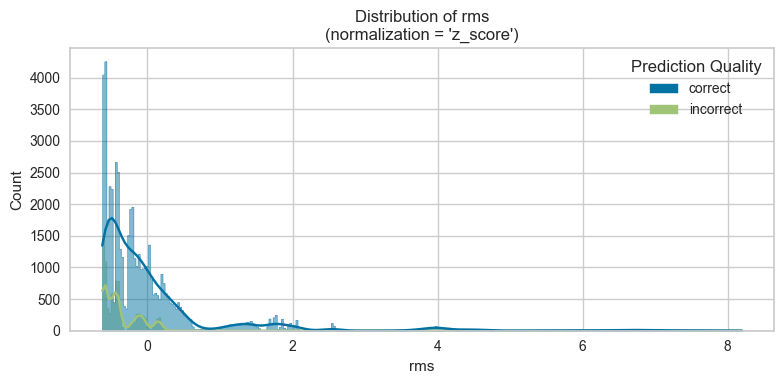

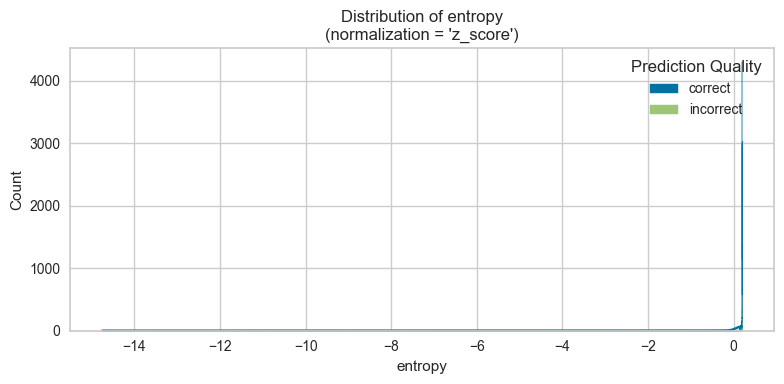

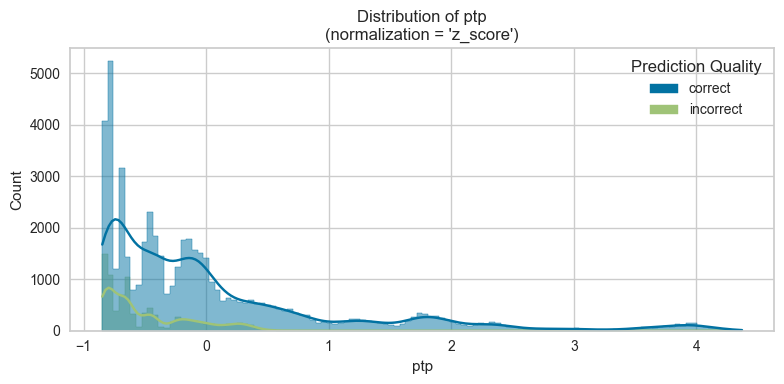

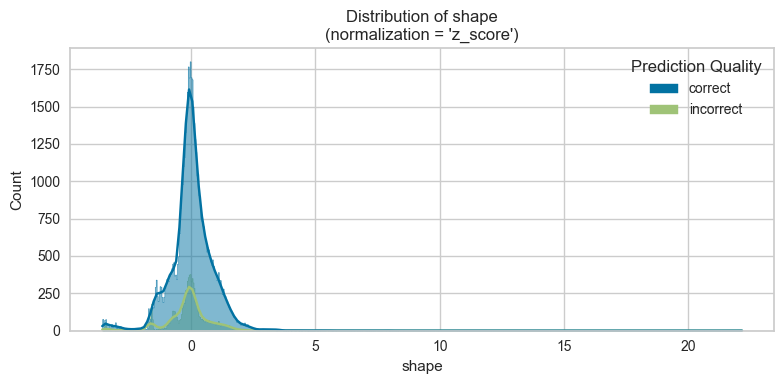

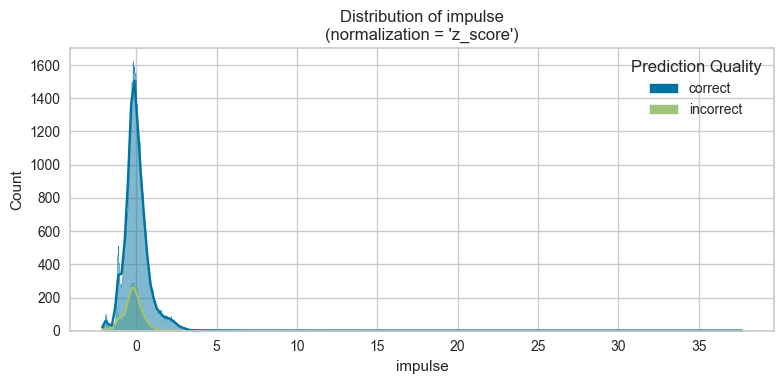

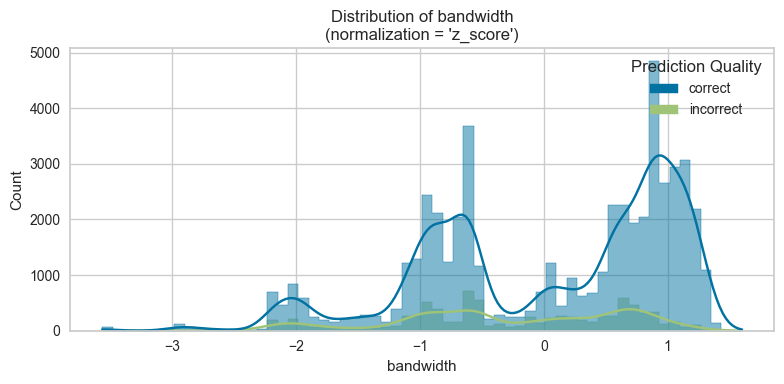

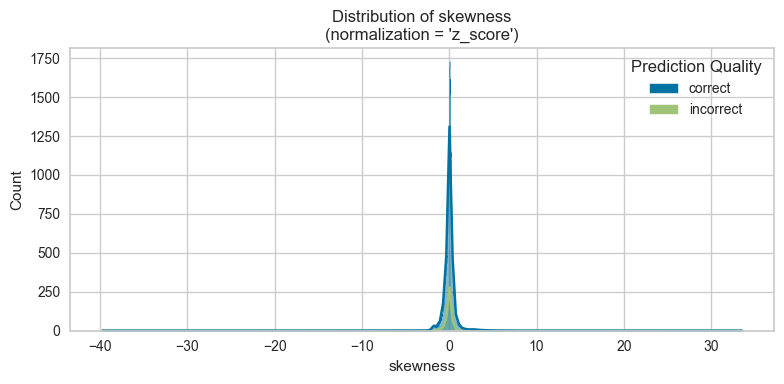

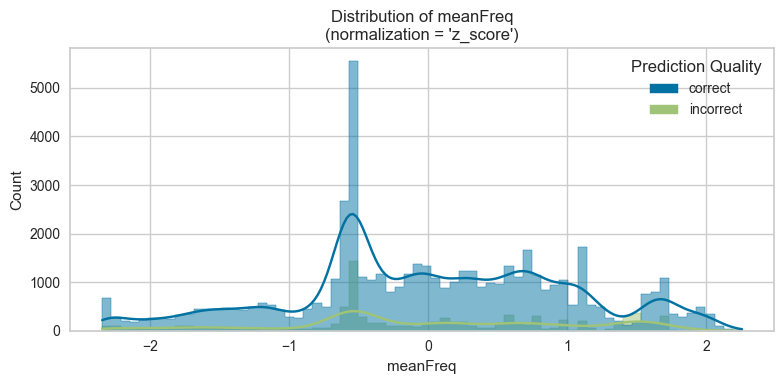

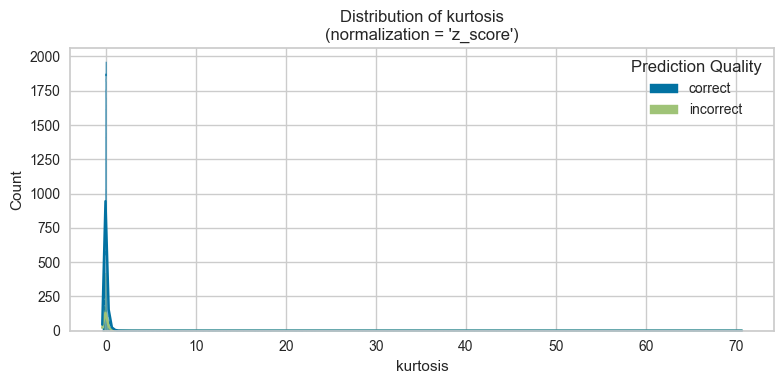

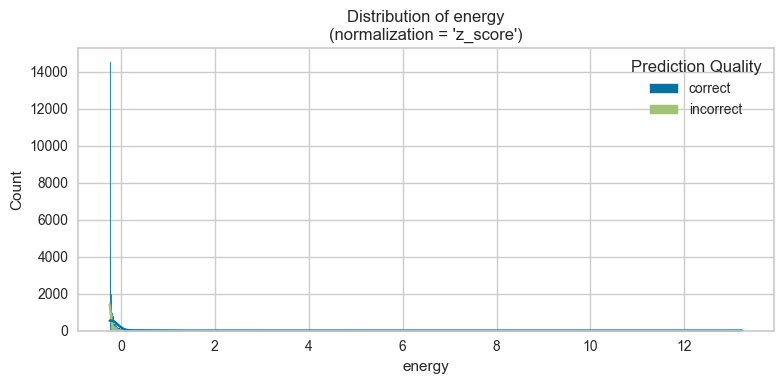

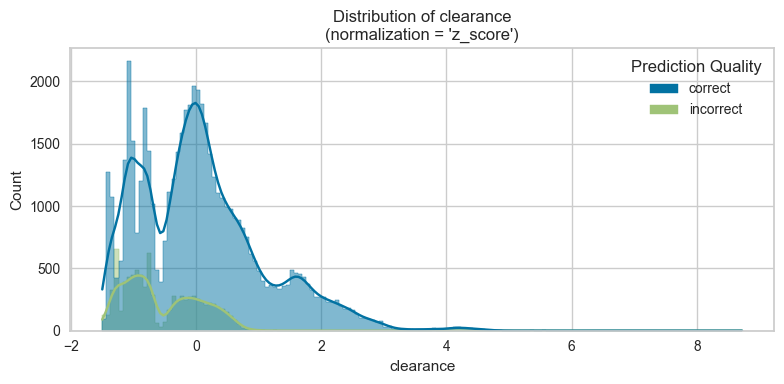

In [55]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [56]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (197087, 16) | Val Shape: (49272, 16) | Test Shape: (61590, 16)


In [57]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [58]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['crest', 'mean', 'medianFreq', 'std', 'rms', 'entropy', 'ptp', 'shape', 'impulse', 'bandwidth', 'skewness', 'meanFreq', 'kurtosis', 'energy', 'clearance']


In [59]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [60]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [61]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [62]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [63]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-04 11:12:44,302 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [64]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-04 11:12:44,358 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-04 11:12:44,389 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-04 11:12:44,544 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-04 11:12:44,588 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-04 11:12:44,651 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  122 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 122 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 122 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

2025-10-04 11:31:48,637 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-04 11:31:48,637 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [65]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9348757863044739     │
│        test_auroc         │    0.9667428135871887     │
│     test_cohen_kappa      │    0.7936950325965881     │
│       test_f1_score       │    0.9348757863044739     │
│   test_hamming_distance   │    0.06512420624494553    │
│    test_jaccard_index     │    0.8191680312156677     │
│         test_loss         │    0.16413840651512146    │
│        test_loss_0        │    0.16413840651512146    │
│  test_matthews_corrcoef   │    0.8077871799468994     │
│      test_precision       │    0.9348757863044739     │
│        test_recall        │    0.9348757863044739     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [66]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [67]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-04 11:32:05,817 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [68]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-04 11:32:05,860 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-04 11:32:05,890 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-04 11:32:06,031 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-04 11:32:06,078 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-04 11:32:06,129 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 11.3 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     34 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 11.3 K                                                                                           
Non-trainable params: 8                                                                                            
Total params: 11.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


2025-10-04 11:50:43,102 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-04 11:50:43,105 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [69]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
93960,0.797503,0.202497,damaged
371,0.110722,0.889278,healthy
33266,0.369653,0.630347,healthy
238774,0.907085,0.092915,damaged
210317,0.734706,0.265294,damaged
16,0.152429,0.847571,healthy
117119,0.907303,0.092697,damaged
258524,0.808588,0.191412,damaged
226017,0.802655,0.197345,damaged
6208,0.150497,0.849503,healthy


In [70]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8805650472640991     │
│        test_auroc         │     0.886785626411438     │
│     test_cohen_kappa      │    0.6065349578857422     │
│       test_f1_score       │    0.8805650472640991     │
│   test_hamming_distance   │    0.11943497508764267    │
│    test_jaccard_index     │    0.6878383755683899     │
│         test_loss         │    0.31952354311943054    │
│        test_loss_0        │    0.31952354311943054    │
│  test_matthews_corrcoef   │    0.6304138898849487     │
│      test_precision       │    0.8805650472640991     │
│        test_recall        │    0.8805650472640991     │
└───────────────────────────┴───────────────────────────┘

In [71]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
11,meanFreq,1.324106
2,medianFreq,1.229332
0,crest,0.545579
3,std,0.532158
14,clearance,0.492769
9,bandwidth,0.449495
13,energy,0.440194
1,mean,0.411990
6,ptp,0.388845
10,skewness,0.387416


In [72]:
add_top_features(gandalf_top_features, top_n=3)

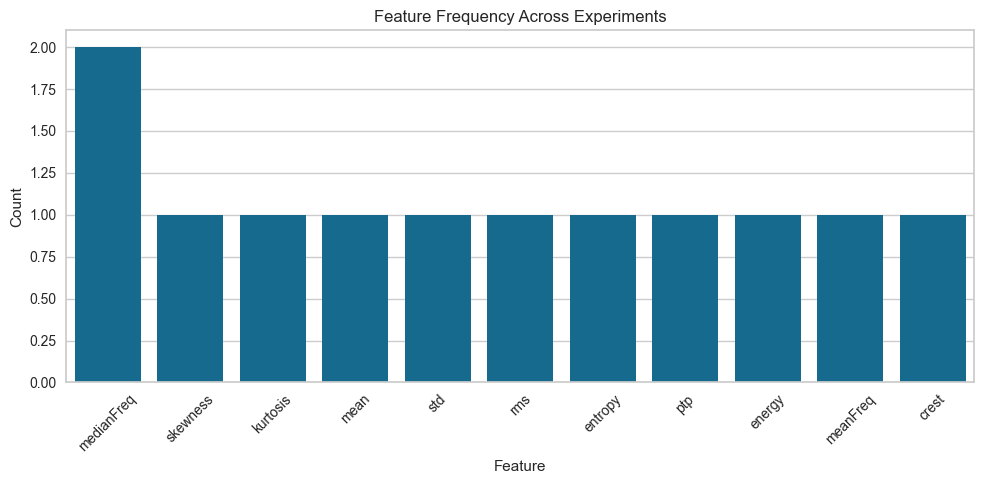

In [73]:
plot_feature_importance()